In [2]:
from sklearn.datasets import fetch_mldata

mnist=fetch_mldata('MNIST original',data_home='./datasets')
mnist

{'DESCR': 'mldata.org dataset: mnist-original',
 'COL_NAMES': ['label', 'data'],
 'target': array([0., 0., 0., ..., 9., 9., 9.]),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

https://blog.csdn.net/weixin_30326745/article/details/101083201   ->解决MNIST数据集无法获取问题  
data:存放一个数组，一行(长784)表示一个样例(即一个数字)，一列(高70000)表示一个特征  
target:标签，共70000个  
mnist数据集中：70000个数字，每个数字大小为784(28*28个像素)特征

In [3]:
X,y=mnist["data"],mnist["target"]

In [4]:
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

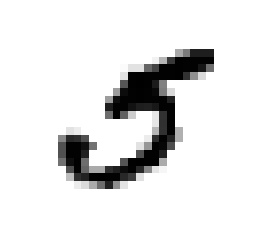

In [6]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
some_digit=X[36000]#选第36000个数字的特征向量
some_digit_image=some_digit.reshape(28,28)
plt.imshow(some_digit_image,cmap=matplotlib.cm.binary,interpolation="nearest")
plt.axis("off") #不显示坐标轴
plt.show()

In [7]:
y[36000]

5.0

In [8]:
#划分训练集和测试集
X_train,X_test,y_train,y_test=X[:60000],X[60000:],y[:60000],y[60000:]

In [9]:
import numpy as np

#打乱数据集，保证交叉验证的每一折都是相似的
shuffle_index=np.random.permutation(60000)
X_train,y_train=X_train[shuffle_index],y_train[shuffle_index]


# 训练一个二分类

In [10]:
#两个类别：“5”和“非5”
y_train_5=(y_train==5) #True、False数组
y_test_5=(y_test==5)

分类器：随机梯度下降SGD,能高效的处理非常大的数据集，因为SGD一次只处理一条数据

In [11]:
from sklearn.linear_model import SGDClassifier
#SGD依赖于训练集的随机程度，若想重现结果，应该固定参数random_state,最大迭代次数5
sgd_clf=SGDClassifier(max_iter=5,random_state=42)
sgd_clf.fit(X_train,y_train_5)#拟合模型

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [12]:
#分类some_digit的值（5）
sgd_clf.predict([some_digit])

array([ True])

猜对啦！！

# 分类器性能评估

In [13]:
#实现交叉验证
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds=StratifiedKFold(n_splits=3,random_state=42) #分层抽样
for train_index,test_index in skfolds.split(X_train,y_train_5):
    clone_clf=clone(sgd_clf)
    X_train_folds=X_train[train_index]
    y_train_folds=y_train_5[train_index]
    
    X_test_fold=X_train[test_index]
    y_test_fold=y_train_5[test_index]
    
    clone_clf.fit(X_train_folds,y_train_folds)#拟合
    y_pred=clone_clf.predict(X_test_fold)
    n_correct=sum(y_pred==y_test_fold)
    print(n_correct/len(y_pred))

0.96445
0.95605
0.95845


In [14]:
#使用cross_val_score()评估SGD模型，同时使用K折交叉验证
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf,X_train,y_train_5,cv=3,scoring="accuracy")

array([0.96445, 0.95605, 0.95845])

In [15]:
#实现非常笨的分类器，看其在“非5”上的表现
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self,X,y=None):
        pass
    def predict(self,X):
        return np.zeros((len(X),1),dtype=bool)
never_5_clf=Never5Classifier()
cross_val_score(never_5_clf,X_train,y_train_5,cv=3,scoring="accuracy")

array([0.911  , 0.9084 , 0.90955])

In [16]:
#计算混淆矩阵
from sklearn.model_selection import cross_val_predict
y_train_pred=cross_val_predict(sgd_clf,X_train,y_train_5,cv=3) #预测值

cross_val_predict()函数使用K折交叉验证，返回基于每个测试折作出的一个预测值

In [17]:
#预测值与实际标签得到混淆矩阵
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5,y_train_pred)

array([[53286,  1293],
       [ 1128,  4293]], dtype=int64)

混淆矩阵中的每一行表示一个实际的类, 而每一列表示一个预测的类。该矩阵的第一行认为“非 5”（反例）中的 53286 张被正确归类为 “非 5”（他们被称为真反例，true negatives）, 而其余 1293 被错误归类为"是 5" （假正例，false positives）。第二行认为“是 5” （正例）中的 1128 被错误地归类为“非 5”（假反例，false negatives），其余 4293 正确分类为 “是 5”类（真正例，true positives）。  

In [19]:
y_train_perfect_predictions=y_train_5
confusion_matrix(y_train_5,y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

一个完美的分类器将只有真反例和真正例，所以混淆矩阵的非零值仅在 其主对角线（左上至右下）

In [20]:
#实际标签与预测标签计算准确率
from sklearn.metrics import precision_score,recall_score
precision_score(y_train_5,y_train_pred) #准确率

0.7685284640171858

In [21]:
4293/(4293+1293) #真正例/(真正例+假正例)

0.7685284640171858

In [22]:
#实际标签与预测标签计算召回率
recall_score(y_train_5,y_train_pred) #召回率

0.7919203099059214

In [23]:
4293/(4293+1128) #真正例/(真正例+假反例)

0.7919203099059214

In [24]:
#计算F1值
from sklearn.metrics import f1_score
f1_score(y_train_5,y_train_pred)

0.7800490596892885

F1值是准确率和召回率的调和平均，普通的平均值平等的看待所有的值，而调和平均会给更小的值更大的权重，  
故，若想得到大的F1值，需要准确率和召回率同时高。

# 准确率/召回率之间的折衷

SGDClassifier分类决策:对于每个样例，根据决策函数计算分数，如果决策分数大于一个阈值，则将样例分配给正例，否则分配给反例。  
sklearn不让直接设置阈值，提供了设置决策分数的方法，调用decision_function()方法，该方法返回每一个样例的分数值，然后基于这个分数值，  
使用任何想要的阈值作出预测。

In [25]:
#每个样例的决策分数
y_scores=sgd_clf.decision_function([some_digit])
y_scores

array([137305.06665008])

In [26]:
#设置阈值
threshold=0
y_some_digit_pred=(y_scores>threshold)
y_some_digit_pred #预测结果

array([ True])

In [27]:
#提高阈值
threshold=2000000
y_some_digit_pred=(y_scores>threshold)
y_some_digit_pred #预测结果

array([False])

提高阈值会增大准确率，降低召回率！！

In [28]:
#计算返回每个样例的决策分数
y_scores=cross_val_predict(sgd_clf,X_train,y_train_5,cv=3,method="decision_function")

In [29]:
#利用标签和对应决策分数返回任何可能阈值的准确率、召回率
from sklearn.metrics import precision_recall_curve

precisions,recalls,thresholds=precision_recall_curve(y_train_5,y_scores)

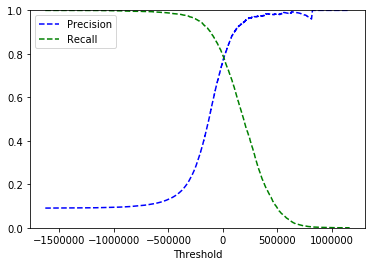

In [32]:
#以阈值为横轴画出准确率和召回率曲线
def plot_precision_recall_vs_threshold(precisions,recalls,thresholds):
    plt.plot(thresholds,precisions[:-1],"b--",label="Precision")
    plt.plot(thresholds,recalls[:-1],"g--",label="Recall")
    plt.xlabel("Threshold") #X轴
    plt.legend(loc="upper left")
    plt.ylim([0,1])
plot_precision_recall_vs_threshold(precisions,recalls,thresholds)
plt.show()

准确率曲线比召回率曲线更加起伏不平的原因：准确率有时会降低，尽管提高阈值的时候，通常来讲准确率会随之提高，   
而当阈值提高的时候，召回率只会降低。  
另一个选出好的准确率/召回率折衷的方法是直接画出准确率对召回率的曲线

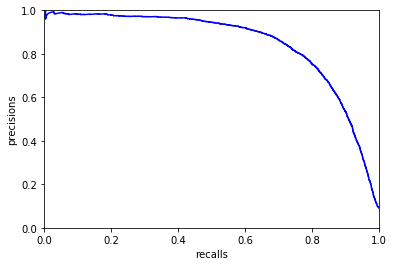

In [33]:
#准确率/召回率曲线
def plot_precision_recall(precisions,recalls):
    plt.plot(recalls,precisions,"b-") #‘-’表实线，'--'表虚线
    plt.axis([0,1,0,1])
    plt.xlabel("recalls")
    plt.ylabel("precisions")
plot_precision_recall(precisions,recalls)
plt.show()

准确率/召回率曲线应尽可能靠近右上角，适合正例很少，或者关注假正例对于假反例的情况。

# ROC曲线

ROC曲线是一种二分类器常用工具，是真正例率(TPR,即召回率)对假正例率(FRP)的曲线。  
FPR是反例被错误分成正例的比率（分成正例的反例/实际总反例数）

In [34]:
#计算不同阈值下的TPR、FPR
from sklearn.metrics import roc_curve
fpr,tpr,thresholds=roc_curve(y_train_5,y_scores)

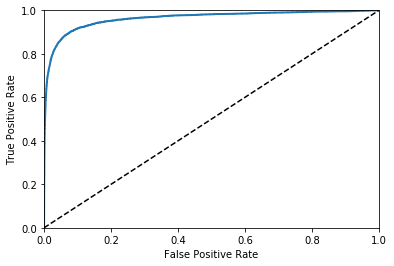

In [35]:
#画出FPR对TPR的曲线
def plot_fpr_tpr(fpr,tpr,label=None):
    plt.plot(fpr,tpr,linewidth=2,label=label)
    plt.plot([0,1],[0,1],"k--")#随机分类器的ROC曲线
    plt.axis([0,1,0,1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
plot_fpr_tpr(fpr,tpr)
plt.show()

召回率（TPR）越高，分类器机会产生越多的假正例（FPR），从左上角至右上角的点线是一个完全随机的分类器产生的ROC曲线；  
一个好的分类器的ROC曲线应该尽可能远离这条点线(即向左上角方向靠拢)。

In [36]:
#测量ROC曲线下的面积（AUC）
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5,y_scores)

0.9629212569718189

比较分类器之间优劣的方法：ROC曲线下的面积。  
完美的分类器的ROC AUC等于1

In [37]:
#训练一个随机森林分类器
from sklearn.ensemble import RandomForestClassifier
forest_clf=RandomForestClassifier(random_state=42)
y_probas_forest=cross_val_predict(forest_clf,X_train,y_train_5,cv=3,
                                 method="predict_proba")

E:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


predict_proba()方法返回一个数组，数组的每行代表一个样例，每列代表一个类别，  
数组中的值的含义：一个样例属于给定类别的概率。

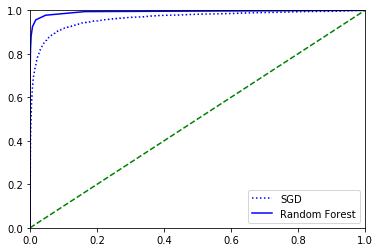

In [38]:
#使用正例的概率当做样例的分数画出ROC曲线
y_scores_forest=y_probas_forest[:,1] #选择数组的第一列的所有值(即所有样本是正例的概率)
fpr_forest,tpr_forest,thresholds_forest=roc_curve(y_train_5,y_scores_forest)
plt.plot(fpr,tpr,"b:",label="SGD") #点线
plt.plot(fpr_forest,tpr_forest,"b-",label="Random Forest") #实线
plt.plot([0,1],[0,1],"g--") #虚线
plt.axis([0,1,0,1])
plt.legend(loc="lower right")
plt.show()

随机森林分类器的ROC曲线比SGD分类器的ROC好,更远绿色离虚线。

In [39]:
#随机森林ROC AUC
roc_auc_score(y_train_5,y_scores_forest)

0.9933781906566126

## 训练一个二分类器：选择合适的标准，使用交叉验证去评估分类器，选择满足需要的准确率/召回率折衷方案，和比较不同模型的ROC曲线和ROC AUC

# 多类分类

一些算法如随机森林分类器或者朴素贝叶斯分类器可以直接处理多类分类问题，其他一些分类器如SVM分类器或者线性分类器则是严格的二分类器，  
二分类器去执行多类分类：  
1. OvA:对于K个类别的分类任务，创建K个二分类器，对每个类别执行二分类任务  
2. OvO:对每一对类别都训练一个二分类器，如K个类别，需要训练K*(K-1)/2个分类器。适用于在训练集的大小上很难扩展的算法，如SVM

In [40]:
#sklearn可以探测出想用一个二分类器去完成多分类任务，会自动执行OvA（SVM分类器会使用OVO）
sgd_clf.fit(X_train,y_train) #二分类器SGD算法执行多分类任务
sgd_clf.predict([some_digit])

array([5.])

幕后sklearn实际训练了10个二分类器，每个分类器都产生一张图片的决策数值，选择数值最高的那个类

In [41]:
#返回10个分类器对图片的决策分数
some_digit_scores=sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-148129.61680732, -420862.1424048 , -412148.08356414,
         -40450.25288928, -619220.40379714,  137305.06665008,
        -607269.09780885, -379376.93239726, -688015.53172112,
        -653905.5088476 ]])

最高数值对应类别5

In [42]:
#强制sklearn使用OvO策略或者OvA策略，使用OneVsOneClassifier或者OneVsRestClassifier
#将一个二分类器传递给构造函数
from sklearn.multiclass import OneVsOneClassifier
ovo_clf=OneVsOneClassifier(SGDClassifier(random_state=42,max_iter=5)) #强制二分类执行OvO策略
ovo_clf.fit(X_train,y_train) #拟合
ovo_clf.predict([some_digit])

array([5.])

In [43]:
len(ovo_clf.estimators_)

45

In [44]:
#训练一个随机森林分类器
forest_clf.fit(X_train,y_train)
forest_clf.predict([some_digit])

array([5.])

In [45]:
#样例对应的类别的概率值
forest_clf.predict_proba([some_digit])

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])

In [46]:
#交叉验证评估分类器
cross_val_score(sgd_clf,X_train,y_train,cv=3,scoring="accuracy")

array([0.86262747, 0.86239312, 0.87673151])

在所有测试折上，有86%的准确度`

In [48]:
#将输入正则化
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
#正则化输入数据
X_train_scaled=scaler.fit_transform(X_train.astype(np.float64))
#3折交叉验证评估模型准确度
cross_val_score(sgd_clf,X_train_scaled,y_train,cv=3,scoring="accuracy")

array([0.910018  , 0.90784539, 0.90898635])

将输入数据正则化后，评估同一模型的准确度，达到90%

# 误差分析

若是实际项目，接下来的工作如下：  
    探索准备数据的候选方案，尝试多种模型，把最好的几个模型列为入围名单，用GridSearchCV调试差参数，尽可能地自动化。  
  
假设已找到不错的模型，改善的方式是：分析模型产生的误差的类型

In [49]:
#检查混淆矩阵
y_train_pred=cross_val_predict(sgd_clf,X_train_scaled,y_train,cv=3)
conf_mx=confusion_matrix(y_train,y_train_pred)
conf_mx

array([[5716,    2,   32,   11,   12,   53,   46,    7,   41,    3],
       [   2, 6442,   44,   27,    6,   55,    7,   15,  132,   12],
       [  57,   33, 5324,  101,   85,   26,   97,   56,  166,   13],
       [  44,   39,  131, 5356,    3,  234,   35,   56,  136,   97],
       [  18,   25,   36,    8, 5370,    9,   48,   34,   75,  219],
       [  68,   36,   32,  198,   76, 4610,  104,   29,  173,   95],
       [  31,   21,   50,    3,   41,   96, 5619,   10,   47,    0],
       [  21,   22,   71,   30,   51,   12,    6, 5807,   15,  230],
       [  49,  143,   68,  172,   17,  163,   56,   29, 5006,  148],
       [  41,   30,   24,   88,  159,   39,    3,  204,   74, 5287]],
      dtype=int64)

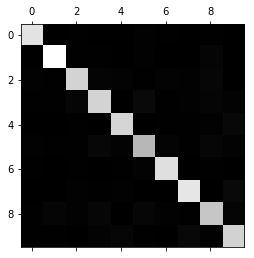

In [50]:
#将混淆矩阵以图像的方式呈现
plt.matshow(conf_mx,cmap=plt.cm.gray)

图片在主对角线上意味着分类正确。  
主对角线第六格的图片看起来要暗淡(其数值最小)，可能是数据集中数字6的图片比较少，  
又或者是分类器对数字6的表现不如其他数字那么好。

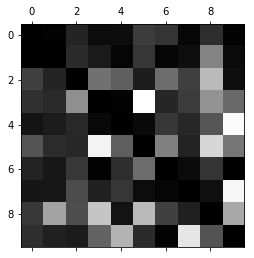

In [51]:
#为比较错误率，将混淆矩阵每个值除以相应类别的图片的总数目（每行代表真实类，每列代表预测类）
row_sums=conf_mx.sum(axis=1,keepdims=True) #对每行横向按列求和
norm_conf_mx=conf_mx/row_sums
np.fill_diagonal(norm_conf_mx,0) #用0填充主对角线，只保留错误分类的数据
plt.matshow(norm_conf_mx,cmap=plt.cm.gray)

行代表实际类别，列代表预测类别  
第8、9列(从0开始)比较亮，代表许多其他图片被误分成数字8或9  
第8、9行表示数字8、9经常被误分成其他数字

In [52]:
import matplotlib as mpl
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

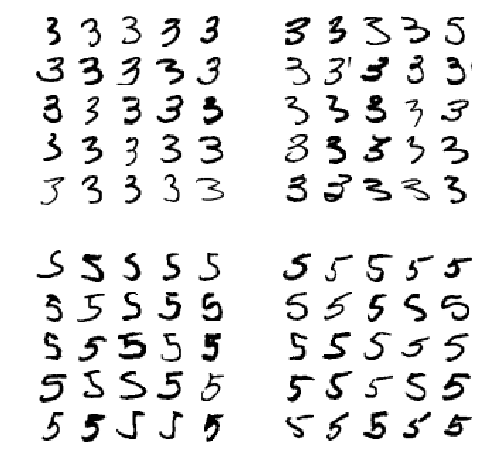

In [53]:
#画出3和5 的列子
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]
plt.figure(figsize=(8,8))
plt.subplot(221)
plot_digits(X_aa[:25],images_per_row=5)
plt.subplot(222)
plot_digits(X_ab[:25],images_per_row=5)

plt.subplot(223)
plot_digits(X_ba[:25],images_per_row=5)
plt.subplot(224)
plot_digits(X_bb[:25],images_per_row=5)
plt.show()

# 多标签分类

例如一个人脸识别器：如果对于同一张图片，它识别出几 个人，它应该做什么？当然它应该给每一个它识别出的人贴上一个标签。比方说，这个分类 器被训练成识别三个人脸，Alice，Bob，Charlie；然后当它被输入一张含有 Alice 和 Bob 的 图片，它应该输出 [1, 0, 1] （意思是：Alice 是，Bob 不是，Charlie 是）。这种输出多个二值标签的分类系统被叫做多标签分类系统

In [54]:
#K近邻分类器测试多标签分类
from sklearn.neighbors import KNeighborsClassifier
y_train_large=(y_train>=7) #标签1(是否为大数)
y_train_odd=(y_train%2==1) #标签2(是否是奇数)
y_multilabel=np.c_[y_train_large,y_train_odd]
knn_clf=KNeighborsClassifier()
knn_clf.fit(X_train,y_multilabel) #拟合

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [55]:
knn_clf.predict([some_digit]) #somge_digit=5

array([[False,  True]])

In [ ]:
#评估多标签分类器: 对每个个体标签去度量F1值，然后计算平均值（执行时间挺长）
y_train_knn_pred=cross_val_predict(knn_clf,X_train,y_train,cv=3)
f1_score(y_train,y_train_knn_pred,average="macro")

# 多输出分类

多输出分类：是多标签分类的简单泛化，每个标签可以使多类别的(比如说，它可以有多于两个的可能值)

建立去除图片噪声的分类器：    
输入：混有噪声的图片  
输出：干净的图片  
该分类器的输出是多标签的(一个像素一个标签),并且每个标签有多个值(像素强度取值范围从0到255)

分类和回归的界限是模糊的，按理说，预测一个像素的强度更像回归任务，而非一个分类任务

In [ ]:
#从MNIST图片创建训练集和测试集,并添加噪声
noise=np.randint(0,100,(len(X_train),784))
X_train_mod=X_train+noise
noise=np.randint(0,100,len(X_test),784)
X_test_mod=X_test+noise

In [ ]:
#新联分类器，清洁噪声
knn_clf.fit(X_train_mod,y_train_mod)
clean_digit=knn_clf.predict([X_test_mod[some_index]])